In [ ]:
import os
os.environ["WANDB_API_KEY"] = "0" # silence the warning

### Using bert-base-multilingual-cased on GPU

This is an interesting competition and good one for NLI with multilingual. An amazing starter Notebook that was given in the competition is pretty good which gives the score of about .65 for just single epoch. I would suggest anyone who starts with this competition to read through that notebook first.

I would like to share this very simple and basic starter notebook using BERT Model with the use of next sentence prediction classification. Most of the models available in the transformer library are mono-lingual models (English, Chinese and German etc.). However, a few multi-lingual models are available and have a different mechanisms than mono-lingual models. I will be using the smaller bert-base-multilingual-cased model in this notebook which supports Masked language modeling + Next sentence prediction for 104 languages.

Tried with both cased and uncased multi-lingual bert models but found the cased gave me better results. Hope this is helpful to those who are starting their experiments in this area.


In [ ]:
import transformers
import torch
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap as wrap
from torch.utils import data
%matplotlib inline
%config InlineBackend.figure_format='retina'
from collections import defaultdict
import re,random
from transformers import XLMRobertaForSequenceClassification
from transformers import XLMRobertaTokenizer

In [ ]:
# constants - config params
RANDOM_SEED = 42
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS=3
LR=5e-6
TEST_SIZE = 0.10
TRAINING_FILE = "../input/contradictory-my-dear-watson/train.csv"
SAMPLE_FILE = "../input/contradictory-my-dear-watson/sample_submission.csv"
TEST_FILE = "../input/contradictory-my-dear-watson/test.csv"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
MODEL_TYPE ='xlm-roberta-large'# "bert-base-multilingual-cased"
MODEL_FILENAME = 'model.bin'

# Seed it - it can be a function or part of config
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True


In [ ]:
if MODEL_TYPE == 'xlm-roberta-large':
    TOKENIZER = XLMRobertaTokenizer.from_pretrained(MODEL_TYPE)
else:
    TOKENIZER = transformers.BertTokenizer.from_pretrained(MODEL_TYPE)

#### Cleanse Data

In [ ]:
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
df_train['plen'] = df_train['premise'].apply(len)
df_train['hlen'] = df_train['hypothesis'].apply(len)
df_train['classes'] = np.where(df_train['label'] == 0, 'Entailment', np.where(df_train['label'] == 1,'Neutral','Contradiction'))
df=df_train;
df_train.head()

In [ ]:
sns.set(font_scale=1.25)
plt.rcParams["figure.figsize"]=(8,6)
sns.countplot(df_train.classes);
sns.set(style="dark")
class_names = ['Entailment','Neutral','Contradiction'];

### Sentence Length

In [ ]:
plt.rcParams["figure.figsize"]=(8,6)
sns.distplot(df_train.plen,kde=True, rug=False, color='red');

In [ ]:
sns.distplot(df_train.hlen, color='blue');

In [ ]:
sns.distplot(df_train.hlen.values + df_train.plen.values, color='green');

### Dataset
Dataset returns encoded input_ids

In [ ]:
class ContradictoryDatasetXlmr(data.Dataset):
    def __init__(self,premise,hypothesis,target,tokenizer,max_len):
        self.premise = premise
        self.hypothesis = hypothesis
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.premise)

    def __getitem__(self, item):
        ptext = str(self.premise[item])
        htext = str(self.hypothesis[item])
        ptext = " ".join(ptext.split())
        htext = " ".join(htext.split())

        # Encoding
        encoding = TOKENIZER.encode_plus(
            ptext, 
            htext, 
            max_length = self.max_len,
            add_special_tokens = True,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            pad_to_max_length=True,
            return_tensors='pt',
        )
        return {
            'ptext': ptext,
            'htext': htext,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.target[item],dtype=torch.long)
        }

In [ ]:
class ContradictoryModelXlmr(nn.Module):
    def __init__(self, n_classes):
        super(ContradictoryModelXlmr,self).__init__()
        self.bert = XLMRobertaForSequenceClassification.from_pretrained(MODEL_TYPE)
        self.bert_drop_1 = nn.Dropout(0.2)
        self.bert_relu = nn.PReLU()
        self.fc = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size)
        self.fc2 = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size)
        self.bn = nn.BatchNorm1d(self.bert.config.hidden_size)
        self.out = nn.Linear(self.bert.config.hidden_size,n_classes) # (768,3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
        )
        output = self.fc(pooled_output[0])
        output = self.bn(output)
        output = self.bert_relu(output)
        output = self.fc2(output)
        output = self.bn(output)
        output = self.out(output)        
        return self.softmax(output)


In [ ]:
df_train, df_val = train_test_split(df_train, test_size=TEST_SIZE,random_state=RANDOM_SEED)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_train.shape, df_val.shape

### Data Loader

Basic data loader

In [ ]:
def create_data_loader_xlmr(df, tokenizer, max_len, bsz, shuffle):
    ds = ContradictoryDatasetXlmr(
        premise=df.premise.to_numpy(),
        hypothesis=df.hypothesis.to_numpy(),
        target=df.label.to_numpy(),
        tokenizer=TOKENIZER,
        max_len = MAX_LEN,
    )
    return data.DataLoader(
        ds,
        batch_size=bsz,
        num_workers=4,
        shuffle=shuffle
    )

train_dl = create_data_loader_xlmr(df_train, tokenizer=TOKENIZER, max_len=MAX_LEN, bsz=TRAIN_BATCH_SIZE,shuffle=True)
val_dl = create_data_loader_xlmr(df_val, tokenizer=TOKENIZER, max_len=MAX_LEN, bsz=VALID_BATCH_SIZE,shuffle=False)

### Optimization

#### AdamW (PyTorch)
* optimizer with weight decay fixed that can be used to fine-tuned models, and

* several schedules in the form of schedule objects that inherit from _LRSchedule:

* a gradient accumulation class to accumulate the gradients of multiple batches

### transformers.get_linear_schedule_with_warmup
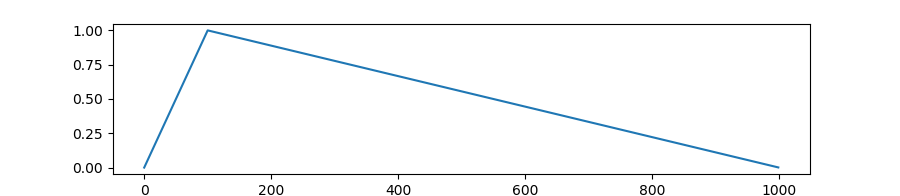

In [ ]:
#model = ContradictoryModel(len(class_names))
model = ContradictoryModelXlmr(len(class_names))
model = model.to(DEVICE)

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

#optimizer 
optimizer = AdamW(optimizer_parameters, lr=LR)
steps = len(train_dl) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)
loss_fn = nn.CrossEntropyLoss().to(DEVICE)

### Training Engine

In [ ]:
def train_fn(model, dl, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    predictions = 0

    #iterate each from dl
    for d in tqdm(dl, total=len(dl), position=0, leave=True):
        input_ids = d['input_ids'].to(DEVICE)
        attention_mask = d['attention_mask'].to(DEVICE)
#        token_type_ids = None #d['token_type_ids'].to(DEVICE, dtype=torch.long)
        targets = d['targets'].to(DEVICE)

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask,
#            token_type_ids = token_type_ids,
        )

        preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        predictions += torch.sum(preds==targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return predictions.double() / n_examples, np.mean(losses)

def eval_fn(model, dl, loss_fn, device, n_examples):
    model.eval()
    losses = []
    predictions = 0

    with torch.no_grad():
        for d in tqdm(dl, total=len(dl), position=0, leave=True):
            input_ids = d['input_ids'].to(DEVICE)
            attention_mask = d['attention_mask'].to(DEVICE)
#            token_type_ids = None # d['token_type_ids'].to(DEVICE, dtype=torch.long)
            targets = d['targets'].to(DEVICE)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask,
#                token_type_ids = token_type_ids,
            )

            preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            predictions += torch.sum(preds==targets)
            losses.append(loss.item())
    return predictions.double() / n_examples, np.mean(losses)

### Runner

### Visualize the Run

In [ ]:
%%time
hist = defaultdict(list)
best_acc = 0
#print(model)
for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1} / {EPOCHS}')
    train_acc, train_loss = train_fn(model,train_dl,loss_fn,optimizer,DEVICE,scheduler,len(df_train))
    print(f'Train loss {train_loss} Accuracy {train_acc}')

    val_acc, val_loss = eval_fn(model,val_dl,loss_fn,DEVICE,len(df_val))
    print(f'Validation loss {val_loss} Accuracy {val_acc}')
    print()

    hist['train_acc'].append(train_acc)
    hist['train_loss'].append(train_loss)
    hist['val_acc'].append(val_acc)
    hist['val_loss'].append(val_loss)

    if val_acc > best_acc:
        torch.save(model.state_dict(),MODEL_FILENAME)
        best_acc = val_acc

In [ ]:
plt.figure(figsize=(8,6))
plt.gca().title.set_text(f'Accuracy Chart')
plt.plot(np.arange(EPOCHS),hist['train_acc'],label='Training')
plt.plot(np.arange(EPOCHS),hist['val_acc'],label='Validation')
plt.legend();

In [ ]:
plt.figure(figsize=(8,6))
plt.gca().title.set_text(f'Loss Chart')
plt.plot(np.arange(EPOCHS),hist['train_loss'],label='Training')
plt.plot(np.arange(EPOCHS),hist['val_loss'],label='Validation')
plt.legend();

In [ ]:
def get_preds(model, data_loader):
    model.eval()
    predictions = []
    prediction_proba = []
 
    with torch.no_grad():
        for d in tqdm(data_loader, total=len(data_loader)):
            input_ids = d['input_ids'].to(DEVICE)
            attention_mask = d['attention_mask'].to(DEVICE)
            token_type_ids = d['token_type_ids'].to(DEVICE, dtype=torch.long)
            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask,
                token_type_ids = token_type_ids,
            )

            _,preds = torch.max(outputs, dim=1)
            predictions.extend(preds)
            prediction_proba.extend(outputs)
    predictions = torch.stack(predictions).cpu()
    prediction_proba = torch.stack(prediction_proba).cpu()

    return predictions, prediction_proba

### Prediction

In [ ]:
model = ContradictoryModelXlmr(len(class_names))
model.load_state_dict(torch.load(MODEL_FILENAME))
model = model.to(DEVICE)
#df_test = pd.read_csv(TEST_FILE)
df_test['label']=-1
test_dl = create_data_loader_xlmr(df_test, tokenizer=TOKENIZER, max_len=MAX_LEN, bsz=TRAIN_BATCH_SIZE,shuffle=False)


In [ ]:
preds, proba = get_preds(model,test_dl)
len(preds)

In [ ]:
df_sample = pd.read_csv(SAMPLE_FILE)

In [ ]:
preds[:10], proba[:10]

In [ ]:
df_sample['prediction']=preds;df_sample.head()

In [ ]:
df_sample.to_csv("submission.csv",index=False)

In [ ]:
!ls ./submission.csv